In [110]:
# Import packages. Download gensim and wordcloud if you haven't.
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
from ipywidgets import widgets, interactive
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.parsing.preprocessing import preprocess_string

In [3]:
# Import datasets
df_train = pd.read_csv('assets/df_train.csv',index_col=0)
df_test = pd.read_csv('assets/df_test.csv',index_col=0)

In [4]:
# Preprocess Strings (Lemmatize, Remove Stopwords, etc.)
df_train['tweet_text'] = df_train['tweet_text'].apply(lambda x:" ".join(preprocess_string(x)))
df_test['tweet_text'] = df_test['tweet_text'].apply(lambda x:" ".join(preprocess_string(x)))

In [5]:
# Train TfIdf vectorizer and remove
vec_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=1,max_features=1000)
X_train_tfidf = vec_tfidf.fit_transform(df_train.tweet_text)
X_test_tfidf = vec_tfidf.transform(df_test.tweet_text)

In [6]:
# map labels to ordinal values
unique_labels = df_train['class_label'].unique()
dict_label = dict(zip(unique_labels,np.arange(len(unique_labels))))
y_train = df_train['class_label'].map(dict_label)
y_test = df_test['class_label'].map(dict_label)

In [7]:
# Create and fit the logistic regressor
lr = LogisticRegression(random_state = 42,max_iter=10000)
lr.fit(X_train_tfidf,y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [8]:
# Test the regressor's performance on the test set.
y_test_predict = lr.predict(X_test_tfidf)
print('Accuracy: ',accuracy_score(y_test,y_test_predict))
print('Precision: ',precision_score(y_test,y_test_predict,average='macro'))
print('Recall: ',recall_score(y_test,y_test_predict,average='macro'))
print('F-1 Score: ',f1_score(y_test,y_test_predict,average='macro'))

Accuracy:  0.7342675832892649
Precision:  0.7293932397980467
Recall:  0.6578913562398816
F-1 Score:  0.6824750204675245


In [55]:
# What are the most important words in identifying each category?
# We can see the most important words are highly
top_words = 10
coef_sorted = np.zeros_like(lr.coef_)
for category_idx in range(lr.coef_.shape[0]):
    index_sort = np.argsort(lr.coef_[category_idx,:])
    top_names = [vec_tfidf.get_feature_names()[index_sort[-i]] for i in range(1,top_words+1)]
    print(unique_labels[category_idx],':',top_names)

other_relevant_information : ['irma', 'flood', 'irma victim', 'climat', 'reason', 'aftershock', 'trump', 'hurricaneharvei', 'irma relief', 'dorian']
displaced_people_and_evacuations : ['evacu', 'evacue', 'displac', 'shelter', 'flee', 'homeless', 'mandatori', 'resid', 'order', 'million peopl']
rescue_volunteering_or_donation_effort : ['donat', 'rescu', 'volunt', 'relief', 'rescuer', 'help', 'aid', 'fundrais', 'rais', 'deliv']
caution_and_advice : ['warn', 'emerg', 'tip', 'tornado', 'danger', 'prepar', 'flood', 'edt', 'hurricaneflor', 'declar']
sympathy_and_support : ['prai', 'prayer', 'thought', 'heart', 'support', 'allah', 'help', 'condol', 'safe', 'hope']
infrastructure_and_utility_damage : ['damag', 'destroi', 'destruct', 'collaps', 'power', 'build', 'home', 'hous', 'road', 'tree']
not_humanitarian : ['trump', 'realdonaldtrump', 'job', 'instead', 'blame', 'fuck', 'kill', 'vote', 'tax', 'nebraska']
requests_or_urgent_needs : ['help', 'need', 'urgent', 'donat', 'food', 'request', 'medi

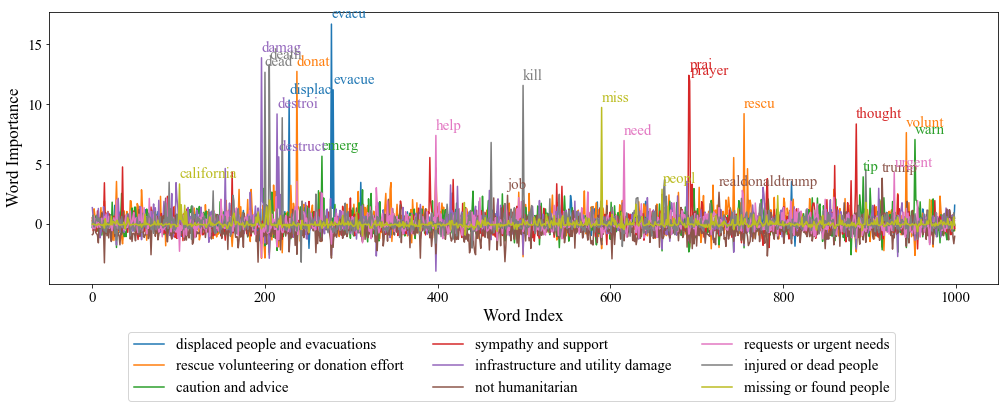

In [56]:
# Personally think this plot is rather good, but some interactivity (selection on figure) might actually be better
fig,ax = plt.subplots(figsize=(17,5))
for category_idx in range(1,lr.coef_.shape[0]):
    ax.plot(np.arange(lr.coef_.shape[1]),lr.coef_[category_idx,:],label=unique_labels[category_idx].replace('_',' '))
    ax.tick_params(labelsize=15)
    ax.set_xlabel("Word Index",fontsize=17)
    ax.set_ylabel("Word Importance",fontsize=17)
    index_sort = np.argsort(lr.coef_[category_idx,:])
    for i in range(-3,0):
        ax.annotate(vec_tfidf.get_feature_names()[index_sort[i]],xy=(index_sort[i],lr.coef_[category_idx,index_sort[i]]+0.5),fontsize=15,color=plt.gca().lines[-1].get_color())
    plt.legend(bbox_to_anchor=(0.9, -0.15),ncol=3,fontsize=15)

In [126]:
# Interactivity plots for each category. 
# I have uploaded a demo video of this part to google drive: https://drive.google.com/file/d/1IHhPBQ5udS1PWJG4IMEJcark8dO00gE4/view?usp=sharing.
# This should come in handy for writing reports.
output = widgets.Output()
unique_labels_transformed = [i.replace('_',' ') for i in list(unique_labels)]

def clicked(b):
    
    output.clear_output(wait=True)
    with output:
        category = filterdrop.value
        if category=='Select One...':
            print('Please Select One Value!')
        else:
            fig,ax = plt.subplots(figsize=(17,5))
            category_idx = unique_labels_transformed.index(category)
            ax.plot(np.arange(lr.coef_.shape[1]),lr.coef_[category_idx,:])
            ax.tick_params(labelsize=15)
            ax.set_xlabel("Word Index",fontsize=17)
            ax.set_ylabel("Word Importance",fontsize=17)
            index_sort = np.argsort(lr.coef_[category_idx,:])
            for i in range(-20,0):
                ax.annotate(vec_tfidf.get_feature_names()[index_sort[i]],xy=(index_sort[i],lr.coef_[category_idx,index_sort[i]]),fontsize=15,color=plt.gca().lines[-1].get_color())
            plt.show()


filterdrop = widgets.Dropdown(
    options = ['Select One...']+list(unique_labels_transformed),
    description = "Category: ",
    disabled = False
)
filterdrop.observe(clicked)
display(filterdrop,output)


Dropdown(description='Category: ', options=('Select One...', 'other relevant information', 'displaced people a…

Output()

In [128]:
# Or alternatively, a wordcloud could be more intuitive.

output = widgets.Output()
unique_labels_transformed = [i.replace('_',' ') for i in list(unique_labels)]

def clicked(b):
    output.clear_output(wait=True)
    with output:
        category = filterdrop.value
        if category=='Select One...':
            print('Please Select One Value!')
        else:
            category_idx = unique_labels_transformed.index(category)
            index_sort = np.argsort(lr.coef_[category_idx,:])
            weights = [(lr.coef_[category_idx,index_sort[-i]],feature_names[index_sort[-i]]) for i in range(1,51)]
            weights = dict(zip([feature_names[index_sort[-i]] for i in range(1,51)],[lr.coef_[category_idx,index_sort[-i]] for i in range(1,51)]))
            wc = WordCloud(background_color='white', stopwords= None, max_words=50)
            wc.generate_from_frequencies(weights)
            plt.figure(figsize=(10,5),facecolor = 'white', edgecolor='blue')
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.tight_layout(pad=0)
            plt.show()


filterdrop = widgets.Dropdown(
    options = ['Select One...']+list(unique_labels_transformed),
    description = "Category: ",
    disabled = False
)
filterdrop.observe(clicked)
display(filterdrop,output)
# unique_str  = ' '.join(feature_names[index_sort[-i]] for i in range(1,21))
# generate_wordcloud(unique_str)

Dropdown(description='Category: ', options=('Select One...', 'other relevant information', 'displaced people a…

Output()

In [102]:
# Failure Analysis. 
failure_idx = [i for i in range(len(y_test)) if y_test.iloc[i]-y_test_predict[i]]
len(failure_idx)

# Feel free to change the idx index to explore. In the case of idx=2, there are two keywords ('finance' and 'evacuate'),
# which caused the classifier to predict wrong (This happens to other indices too, such as idx=5).
idx = 2
print(df_test.tweet_text.iloc[failure_idx[idx]])
print('True Label: ',unique_labels[y_test.iloc[failure_idx[idx]]])
print('Predicted Label: ',unique_labels[y_test_predict[failure_idx[idx]]])

happyfollowback financi relief wildfir evacue teamfollowback
True Label:  rescue_volunteering_or_donation_effort
Predicted Label:  displaced_people_and_evacuations


In [132]:
# I'm also curious as to whether the tweets can help identify which disaster it is.
unique_labels_disaster = df_train['disaster'].unique()
dict_label_disaster = dict(zip(unique_labels_disaster,np.arange(len(unique_labels))))
y_train_disaster = df_train['disaster'].map(dict_label)
y_test_disaster = df_test['disaster'].map(dict_label)
lr_disaster = LogisticRegression(random_state = 42,max_iter=10000)
lr_disaster.fit(X_train_tfidf,y_train_disaster)
y_test_predict_disaster = lr_disaster.predict(X_test_tfidf)
print('Accuracy: ',accuracy_score(y_test_disaster,y_test_predict_disaster))
print('Precision: ',precision_score(y_test_disaster,y_test_predict_disaster,average='macro'))
print('Recall: ',recall_score(y_test_disaster,y_test_predict_disaster,average='macro'))
print('F-1 Score: ',f1_score(y_test_disaster,y_test_predict_disaster,average='macro'))

Accuracy:  0.9243786356425172
Precision:  0.9340826703109196
Recall:  0.9256183633873235
F-1 Score:  0.9295862267830831


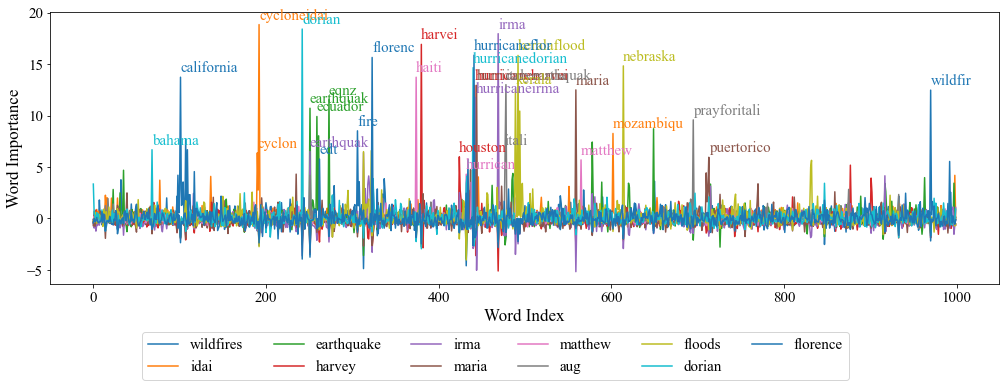

In [142]:
# Plot out word importance graph. Not surprisingly, many tweets already explicitly include disaster information.
fig,ax = plt.subplots(figsize=(17,5))
for category_idx in range(lr_disaster.coef_.shape[0]):
    ax.plot(np.arange(lr_disaster.coef_.shape[1]),lr_disaster.coef_[category_idx,:],label=unique_labels_disaster[category_idx])
    ax.tick_params(labelsize=15)
    ax.set_xlabel("Word Index",fontsize=17)
    ax.set_ylabel("Word Importance",fontsize=17)
    index_sort = np.argsort(lr_disaster.coef_[category_idx,:])
    for i in range(-3,0):
        ax.annotate(vec_tfidf.get_feature_names()[index_sort[i]],xy=(index_sort[i],lr_disaster.coef_[category_idx,index_sort[i]]+0.5),fontsize=15,color=plt.gca().lines[-1].get_color())
    plt.legend(bbox_to_anchor=(0.85, -0.15),ncol=6,fontsize=15)

In [ ]:
# Additional notes: will the scraped tweet info (creation date, like/retweet statistics, etc.) improve the classification performance?